In [1]:
from couplevae import *
import scanpy as sc

In [2]:
train_path = "data\\train\\train_fate.h5ad"
valid_path = "data\\valid\\valid_fate.h5ad"
test_path = "data\\test\\test_fate.h5ad"

In [3]:
train = sc.read(train_path)
valid = sc.read(valid_path)
test = sc.read(test_path) 

In [4]:
train

AnnData object with n_obs × n_vars = 68058 × 1622
    obs: 'time', 'population', 'batch'

In [5]:
train.obs["population"]

0-0        b'Lin-Kit+Sca1-'
1-0        b'Lin-Kit+Sca1-'
2-0        b'Lin-Kit+Sca1-'
3-0        b'Lin-Kit+Sca1-'
4-0        b'Lin-Kit+Sca1-'
                 ...       
49348-1    b'Lin-Kit+Sca1+'
49349-1    b'Lin-Kit+Sca1+'
49350-1    b'Lin-Kit+Sca1+'
49351-1    b'Lin-Kit+Sca1+'
49352-1    b'Lin-Kit+Sca1+'
Name: population, Length: 68058, dtype: category
Categories (2, object): ['b'Lin-Kit+Sca1+'', 'b'Lin-Kit+Sca1-'']

In [6]:
valid.obs['batch']

0-0       0
1-0       0
2-0       0
3-0       0
4-0       0
         ..
5998-1    1
5999-1    1
6000-1    1
6001-1    1
6002-1    1
Name: batch, Length: 8319, dtype: category
Categories (2, object): ['0', '1']

In [7]:
valid.obs['time'].value_counts()

2    2773
4    2773
6    2773
Name: time, dtype: int64

In [8]:
test.obs['time'].value_counts()

2    2790
4    2790
6    2790
Name: time, dtype: int64

In [9]:
data_name = "fate"
cell_type = "b'Lin-Kit+Sca1-'"
condition_key = "time"
cell_type_key = "population"
pert_key = 4
ctrl_key = 2
pred_key = 6
device = "cuda:0"

In [10]:
trainloader = load_h5ad_to_dataloader(train, condition_key, cell_type_key, 
                                    cell_type, ctrl_key, pert_key, device)
validloader = load_h5ad_to_dataloader(valid, condition_key, cell_type_key, 
                                    cell_type, ctrl_key, pert_key, device)

In [11]:
test_adata_c = test[(test.obs[condition_key]==ctrl_key)&(test.obs[cell_type_key]==cell_type)]  
test_adata_p = test[(test.obs[condition_key]==pred_key)&(test.obs[cell_type_key]==cell_type)]

In [12]:
test_adata_p

View of AnnData object with n_obs × n_vars = 786 × 1622
    obs: 'time', 'population', 'batch'

In [13]:
# Create Model
network = VAE(x_dim=train.X.shape[1],
              z_dim=200,
              alpha=0.00005,
              beta=0.05,
              dropout_rate=0.1,
              learning_rate=0.0001)

d:\anaconda\envs\couplevae_env\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [14]:
trainer = Trainer(model=network, learning_rate=0.0001, n_epochs=500, patience=20, batch_size=32)

In [15]:
# Train
trainer.train(train_loader=trainloader, valid_loader=validloader)

d:\anaconda\envs\couplevae_env\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch 1, Train Loss: 304.3132, Validation Loss: 260.7947
Epoch 2, Train Loss: 255.4469, Validation Loss: 242.5286
Epoch 3, Train Loss: 242.8329, Validation Loss: 236.4733
Epoch 4, Train Loss: 236.9349, Validation Loss: 232.2253
Epoch 5, Train Loss: 232.6800, Validation Loss: 229.1537
Epoch 6, Train Loss: 229.5599, Validation Loss: 226.9889
Epoch 7, Train Loss: 226.8889, Validation Loss: 225.0800
Epoch 8, Train Loss: 224.4493, Validation Loss: 223.5130
Epoch 9, Train Loss: 221.9897, Validation Loss: 221.7719
Epoch 10, Train Loss: 219.5893, Validation Loss: 220.2671
Epoch 11, Train Loss: 217.4233, Validation Loss: 219.6473
Epoch 12, Train Loss: 215.1056, Validation Loss: 217.7904
Epoch 13, Train Loss: 213.0281, Validation Loss: 216.6584
Epoch 14, Train Loss: 211.0422, Validation Loss: 215.2634
Epoch 15, Train Loss: 209.0006, Validation Loss: 214.8626
Epoch 16, Train Loss: 207.2773, Validation Loss: 213.4901
Epoch 17, Train Loss: 205.4520, Validation Loss: 212.4047
Epoch 18, Train Loss: 2

In [16]:
# pred, shap_c_vals, shap_p_vals = network.predict_with_shap(test_adata_c, test_adata_p)

In [17]:
test_adata_c

View of AnnData object with n_obs × n_vars = 786 × 1622
    obs: 'time', 'population', 'batch'

In [18]:
# Test
pred = network.predict(test_adata_c, test_adata_p)

In [19]:
pred

array([[0.        , 0.        , 0.        , ..., 0.        , 0.7084995 ,
        0.3774131 ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.5606029 ,
        0.15439576],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.8018979 ,
        0.24437964],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.15365034],
       [0.        , 0.        , 0.        , ..., 0.        , 0.5773517 ,
        0.        ]], dtype=float32)

In [20]:
from couplevae import *
import anndata
import numpy as np
import scanpy as sc
import seaborn as sns

import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import issparse
from adjustText import adjust_text

In [21]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from scipy.optimize import curve_fit
# from adjustText import adjust_text
# from scipy.sparse import issparse
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import r2_score

# # Non-linear model: e.g., quadratic
# def quadratic(x, a, b, c):
#     return a * x**2 + b * x + c

# def plot_gene_correlation(data, cond_col, axes_map, label_map, file_path='./output_plot.pdf', 
#                           genes_of_interest=None, top_genes=None, show_plot=False, include_legend=True, 
#                           plot_title='', x_offset=0.3, y_offset=0.8, text_size=14,
#                           rf_params=None, plot_rf=True):
#     """
#     Parameters:
#     rf_params: dict - Parameters for RandomForestRegressor (e.g., {'n_estimators': 100})
#     plot_rf: bool - Whether to plot random forest predictions
#     """
#     # Check if optional parameters were passed and set default values
#     if genes_of_interest is None:
#         genes_of_interest = []
#     if top_genes is None:
#         top_genes = []
#     if rf_params is None:
#         rf_params = {'n_estimators': 100, 'random_state': 42}

#     # Convert sparse matrix to dense matrix
#     if issparse(data.X):
#         data.X = data.X.toarray()

#     # Retrieve groups of cells based on the condition
#     group_y = data[data.obs[cond_col] == axes_map['y'], :]
#     group_x = data[data.obs[cond_col] == axes_map['x'], :]

#     # If top_genes are provided, handle the differential gene part
#     if len(top_genes) > 0:
#         subset_data_x = group_x[:, top_genes].X
#         subset_data_y = group_y[:, top_genes].X

#         avg_x_genes = np.mean(subset_data_x, axis=0)
#         avg_y_genes = np.mean(subset_data_y, axis=0)

#         # Calculate R² value
#         r_squared_top = np.corrcoef(avg_x_genes, avg_y_genes)[0, 1] ** 2
#         print(f'R-squared for top genes: {r_squared_top:.2f}')

#     # Compute the average expression for all genes
#     avg_x = np.mean(group_x.X, axis=0)
#     avg_y = np.mean(group_y.X, axis=0)

#     # Calculate R² value for linear correlation
#     r_squared_all = np.corrcoef(avg_x, avg_y)[0, 1] ** 2
#     print(f'R-squared for all genes: {r_squared_all:.2f}')

#     # Create a DataFrame with x and y data
#     df = pd.DataFrame({label_map['x']: avg_x, label_map['y']: avg_y})

#     # Create a scatter plot
#     plt.figure(figsize=(10, 8))
#     ax = sns.scatterplot(x=label_map['x'], y=label_map['y'], data=df, s=10, color='black', alpha=0.6)

#     # ===== 1. Quadratic Curve Fitting =====
#     popt, _ = curve_fit(quadratic, avg_x, avg_y)
#     x_range = np.linspace(min(avg_x), max(avg_x), 100)
#     y_quad = quadratic(x_range, *popt)
#     plt.plot(x_range, y_quad, color='green', label='Quadratic Fit', lw=2)
    
#     # Calculate R² for quadratic model
#     y_quad_pred = quadratic(avg_x, *popt)
#     r_squared_quad = r2_score(avg_y, y_quad_pred)
#     print(f'R-squared (Quadratic): {r_squared_quad:.4f}')

#     # ===== 2. Random Forest Regression =====
#     if plot_rf:
#         # Prepare data for RF (reshape to 2D array)
#         X = avg_x.reshape(-1, 1)
#         y = avg_y
        
#         # Initialize and train Random Forest
#         rf = RandomForestRegressor(**rf_params)
#         rf.fit(X, y)
        
#         # Predict and sort for smooth curve
#         y_rf = rf.predict(x_range.reshape(-1, 1))
#         sorted_idx = np.argsort(x_range)
#         x_sorted = x_range[sorted_idx]
#         y_rf_sorted = y_rf[sorted_idx]
        
#         plt.plot(x_sorted, y_rf_sorted, color='red', 
#                  linestyle='--', label='Random Forest', lw=2)
        
#         # Calculate R² for RF
#         r_squared_rf = rf.score(X, y)
#         print(f'R-squared (Random Forest): {r_squared_rf:.4f}')
#     else:
#         r_squared_rf = None

#     # ===== Plot Configuration =====
#     plt.xlabel(label_map['x'], fontsize=text_size)
#     plt.ylabel(label_map['y'], fontsize=text_size)
#     plt.grid(alpha=0.2)

#     if plot_title:
#         plt.title(plot_title, fontsize=text_size+2)

#     # Label genes of interest
#     if len(genes_of_interest) > 0:
#         texts = []
#         for gene in genes_of_interest:
#             gene_idx = np.where(data.var_names == gene)[0][0]
#             x_pos = avg_x[gene_idx]
#             y_pos = avg_y[gene_idx]
#             texts.append(plt.text(x_pos, y_pos, gene, fontsize=10, 
#                                  color='blue', weight='bold'))
#             plt.scatter(x_pos, y_pos, color='red', s=60, edgecolor='black', zorder=3)
#         adjust_text(texts, arrowprops=dict(arrowstyle="->", color='grey', lw=0.5))

#     # Add R² annotations
#     text_y_pos = max(avg_y) * 0.95
#     plt.text(min(avg_x), text_y_pos, 
#              r'$R^2_{all}: ' + f"{r_squared_all:.3f}$", 
#              fontsize=text_size, ha='left')
    
#     plt.text(min(avg_x), text_y_pos - max(avg_y)*0.07, 
#              r'$R^2_{quad}: ' + f"{r_squared_quad:.3f}$", 
#              fontsize=text_size, ha='left', color='green')
    
#     if plot_rf:
#         plt.text(min(avg_x), text_y_pos - max(avg_y)*0.14, 
#                  r'$R^2_{RF}: ' + f"{r_squared_rf:.3f}$", 
#                  fontsize=text_size, ha='left', color='red')
    
#     if len(top_genes) > 0:
#         plt.text(min(avg_x), text_y_pos - max(avg_y)*0.21, 
#                  r'$R^2_{top}: ' + f"{r_squared_top:.3f}$", 
#                  fontsize=text_size, ha='left')

#     if include_legend:
#         plt.legend(loc='best', fontsize=text_size-2)

#     plt.tight_layout()
#     plt.savefig(file_path, dpi=300, bbox_inches='tight')
    
#     if show_plot:
#         plt.show()
        
#     plt.close()
    
#     # Return model metrics if needed
#     return {
#         'r2_all': r_squared_all,
#         'r2_quad': r_squared_quad,
#         'r2_rf': r_squared_rf if plot_rf else None,
#         'rf_model': rf if plot_rf else None
#     }

In [22]:
def plot_gene_correlation(data, cond_col, axes_map, label_map, file_path='./output_plot.pdf', 
                          genes_of_interest=None, top_genes=None, show_plot=False, include_legend=True, 
                          plot_title='', x_offset=0.05, y_offset=0.95, text_size=14, reg_type='mean'):
    import numpy as np
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    from adjustText import adjust_text
    from scipy.sparse import issparse

    sns.set(style="white", context="notebook")  # 或 'talk', 'paper'
    plt.rcParams['axes.linewidth'] = 1.2  # 坐标轴线宽
    plt.rcParams['xtick.major.width'] = 1.2
    plt.rcParams['ytick.major.width'] = 1.2

    if genes_of_interest is None:
        genes_of_interest = []
    if top_genes is None:
        top_genes = []

    if issparse(data.X):
        data.X = data.X.toarray()

    group_y = data[data.obs[cond_col] == axes_map['y'], :]
    group_x = data[data.obs[cond_col] == axes_map['x'], :]

    # 选择均值或方差
    if reg_type == 'mean':
        avg_func = np.mean
    elif reg_type == 'var':
        avg_func = np.var
    else:
        raise ValueError("reg_type must be 'mean' or 'var'")

    r_squared_top = None
    if len(top_genes) > 0:
        subset_data_x = group_x[:, top_genes].X
        subset_data_y = group_y[:, top_genes].X
        avg_x_genes = avg_func(subset_data_x, axis=0)
        avg_y_genes = avg_func(subset_data_y, axis=0)
        r_squared_top = np.corrcoef(avg_x_genes, avg_y_genes)[0, 1] ** 2
        print(f'R-squared for top genes: {r_squared_top:.2f}')

    avg_x = avg_func(group_x.X, axis=0)
    avg_y = avg_func(group_y.X, axis=0)
    r_squared_all = np.corrcoef(avg_x, avg_y)[0, 1] ** 2
    print(f'R-squared for all genes: {r_squared_all:.2f}')

    df = pd.DataFrame({label_map['x']: avg_x, label_map['y']: avg_y})

    sns.set_style("white")
    fig, ax = plt.subplots(figsize=(4, 4))

    sns.regplot(x=label_map['x'], y=label_map['y'], data=df,
                scatter_kws={'s': 60, 'alpha': 0.5},
                line_kws={'color': 'green'}, ax=ax)

    ax.set_xlabel(label_map['x'], fontsize=text_size)
    ax.set_ylabel(label_map['y'], fontsize=text_size)
    ax.grid(False)

    if plot_title:
        ax.set_title(plot_title, fontsize=text_size)

    # 标注基因
    texts = []
    for gene in genes_of_interest[:10]:
        if gene in data.var_names:
            gene_idx = np.where(data.var_names == gene)[0][0]
            x_pos = avg_x[gene_idx]
            y_pos = avg_y[gene_idx]
            texts.append(ax.text(x_pos, y_pos, gene, fontsize=10, color='black'))
            ax.scatter(x_pos, y_pos, color='red', s=60, zorder=3)
    if texts:
        adjust_text(texts, arrowprops=dict(arrowstyle="->", color='gray', lw=0.6))

    # 使用 ax.transAxes 保证一致位置
    ax.text(x_offset, y_offset,
            r'$R^2_{\mathrm{all\ genes}}$' + f" = {r_squared_all:.2f}",
            transform=ax.transAxes, fontsize=text_size)

    if r_squared_top is not None:
        ax.text(x_offset, y_offset - 0.1,
                r'$R^2_{\mathrm{top\ 100\ DEGs}}$' + f" = {r_squared_top:.2f}",
                transform=ax.transAxes, fontsize=text_size)

    if include_legend:
        ax.legend(loc='best')

    plt.tight_layout()
    if file_path:
        plt.savefig(file_path, bbox_inches='tight', dpi=300)
    if show_plot:
        plt.show()
    plt.close()


In [23]:
# Save
pred_adata = anndata.AnnData(pred, 
                             obs={condition_key: [f"{cell_type}_pred_pert"] * len(pred),
                                  cell_type_key: [cell_type] * len(pred)},
                             var={"var_names": test_adata_c.var_names})

In [24]:
pred_adata.obs["time"]

0      b'Lin-Kit+Sca1-'_pred_pert
1      b'Lin-Kit+Sca1-'_pred_pert
2      b'Lin-Kit+Sca1-'_pred_pert
3      b'Lin-Kit+Sca1-'_pred_pert
4      b'Lin-Kit+Sca1-'_pred_pert
                  ...            
781    b'Lin-Kit+Sca1-'_pred_pert
782    b'Lin-Kit+Sca1-'_pred_pert
783    b'Lin-Kit+Sca1-'_pred_pert
784    b'Lin-Kit+Sca1-'_pred_pert
785    b'Lin-Kit+Sca1-'_pred_pert
Name: time, Length: 786, dtype: object

In [25]:
if issparse(test_adata_c.X):
    test_adata_c.X = test_adata_c.X.A
else:
    test_adata_c.X = test_adata_c.X
ctrl_adata = anndata.AnnData(test_adata_c.X,
                             obs={condition_key: [f"{cell_type}_ctrl"] * len(test_adata_c),
                                  cell_type_key: [cell_type] * len(test_adata_c)},
                             var={"var_names": test_adata_c.var_names})

d:\anaconda\envs\couplevae_env\Lib\site-packages\anndata\_core\anndata.py:602: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
C:\Users\jerry-ai\AppData\Local\Temp\ipykernel_30376\1873556746.py:4: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  test_adata_c.X = test_adata_c.X


In [26]:
if issparse(test_adata_p.X):
    test_adata_p.X = test_adata_p.X.A
else:
    test_adata_p.X = test_adata_p.X

d:\anaconda\envs\couplevae_env\Lib\site-packages\anndata\_core\anndata.py:602: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
C:\Users\jerry-ai\AppData\Local\Temp\ipykernel_30376\3848477140.py:4: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  test_adata_p.X = test_adata_p.X


In [27]:
real_stim_adata = anndata.AnnData(test_adata_p.X,
                                  obs={condition_key: [f"{cell_type}_real_pert"] * len(test_adata_p),
                                       cell_type_key: [cell_type] * len(test_adata_p)},
                                  var={"var_names": test_adata_p.var_names})

In [28]:
all_data = ctrl_adata.concatenate(pred_adata, real_stim_adata)
all_data.write_h5ad(f"coupleVAE{data_name}_{cell_type}_ot_diffusion_kan_{data_name}_{pert_key}_pred{pred_key}.h5ad")

C:\Users\jerry-ai\AppData\Local\Temp\ipykernel_30376\865393140.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  all_data = ctrl_adata.concatenate(pred_adata, real_stim_adata)


In [29]:
all_data

AnnData object with n_obs × n_vars = 2358 × 1622
    obs: 'time', 'population', 'batch'

In [30]:
result=sc.read(f"coupleVAE{data_name}_{cell_type}_ot_diffusion_kan_{data_name}_{pert_key}_pred{pred_key}.h5ad")

In [31]:
result

AnnData object with n_obs × n_vars = 2358 × 1622
    obs: 'time', 'population', 'batch'

In [32]:
sc.tl.rank_genes_groups(result,groupby="time",n_genes=100,method="wilcoxon")

In [33]:
result

AnnData object with n_obs × n_vars = 2358 × 1622
    obs: 'time', 'population', 'batch'
    uns: 'rank_genes_groups'

In [34]:
diff_genes_covid=result.uns["rank_genes_groups"]["names"][f"{cell_type}_real_pert"]
conditions={"ctrl":f"{cell_type}_ctrl","pred_stim":f"{cell_type}_pred_pert","real_stim":f"{cell_type}_real_pert"}

In [35]:
diff_genes_covid

array(['Fcer1g', 'S100a6', 'Gsn', 'Itgb2', 'Vim', 'Anxa1', 'Tyrobp',
       'Cd53', 'Ctsd', 'Wfdc21', 'Ccl6', 'Lcn2', 'Nfkbia', 'Pf4', 'Itgam',
       'Ctsb', 'Lgals3', 'Msrb1', 'Ltf', 'Psap', 'Cd33', 'Gda', 'Chil3',
       'Lipg', 'Sirpa', 'Fcgr3', 'Camp', 'Cd52', 'P2rx1', 'Ly6i', 'Myo1f',
       'Cpa3', 'Trp53inp2', 'Cd9', 'Gstm1', 'Itgb2l', 'Bri3', 'Litaf',
       'Ceacam10', 'Cdk18', 'Cd93', 'Id2', 'Prdx5', 'Pknox2', 'Csf2rb',
       'Ifit1bl2', 'Mcemp1', 'Tpsg1', 'Cd177', 'Nrip3', 'Cobl', 'Fcer1a',
       'Crispld2', 'Dennd1c', 'Sgpl1', 'Rap1b', 'Ifitm6', 'Ftl1',
       'Rap1gap2', 'Slc39a2', 'Cd274', 'Ampd3', 'A930007I19Rik', 'Igf2r',
       'St3gal5', 'Plekhg1', 'Sh3bgrl2', 'Trp53inp1', 'Cd300ld', 'Cdh17',
       'Tpsb2', 'Prg2', 'AB124611', 'Emp1', 'Gzmb', 'Krt83', 'Ppbp',
       'Gem', 'F2r', 'Fgfr1', 'Ctla2a', 'Syne1', 'Mpeg1', 'Tph1', 'Gnaz',
       'Fabp4', 'Lrg1', 'Lrrc56', 'Atf3', 'Mirt1', 'Plekhm3', 'Creb3l1',
       'Gadd45g', 'Hcar2', 'Wfdc17', 'Clec4b2', 'Rxra', 'Notc

In [36]:
diff_genes_covid_list = diff_genes_covid.tolist()

In [37]:
%config InlineBackend.figure_format = 'retina'

R-squared for top genes: 0.99
R-squared for all genes: 0.98


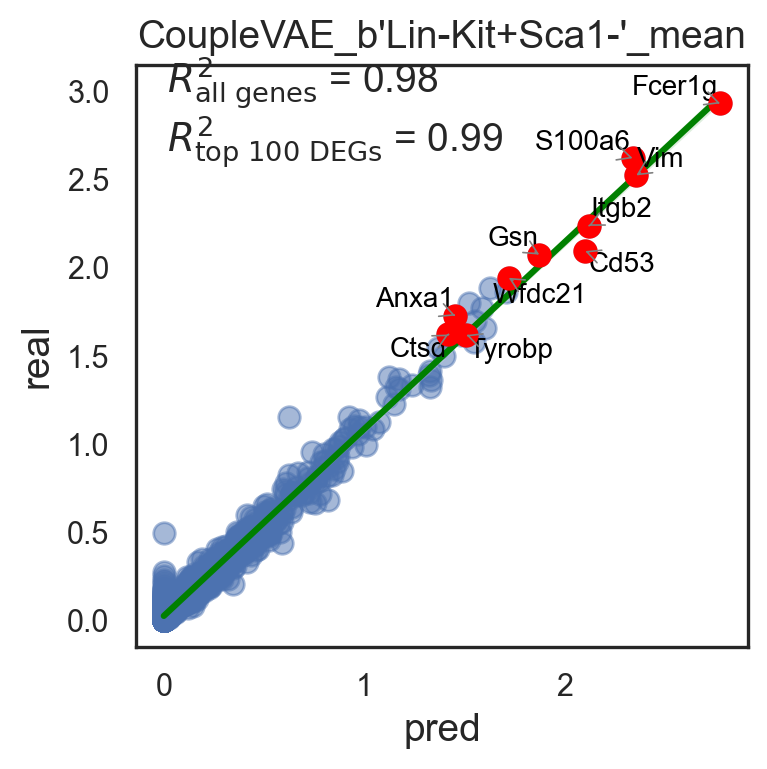

In [38]:
plot_gene_correlation(result, 
                      cond_col="time",
                      axes_map={"x":conditions["pred_stim"],"y":conditions["real_stim"]},
                      genes_of_interest=diff_genes_covid[:30],
                      top_genes=diff_genes_covid,
                      include_legend=False,
                      label_map={"x":"pred","y":"real"},
                      plot_title=f"CoupleVAE_{cell_type}_mean",
                      file_path=f"CoupleVAE_{cell_type}_ot_diffusion_kan_{data_name}_{pert_key}.pdf",
                      show_plot=True,
                      ) 

R-squared for top genes: 0.93
R-squared for all genes: 0.87


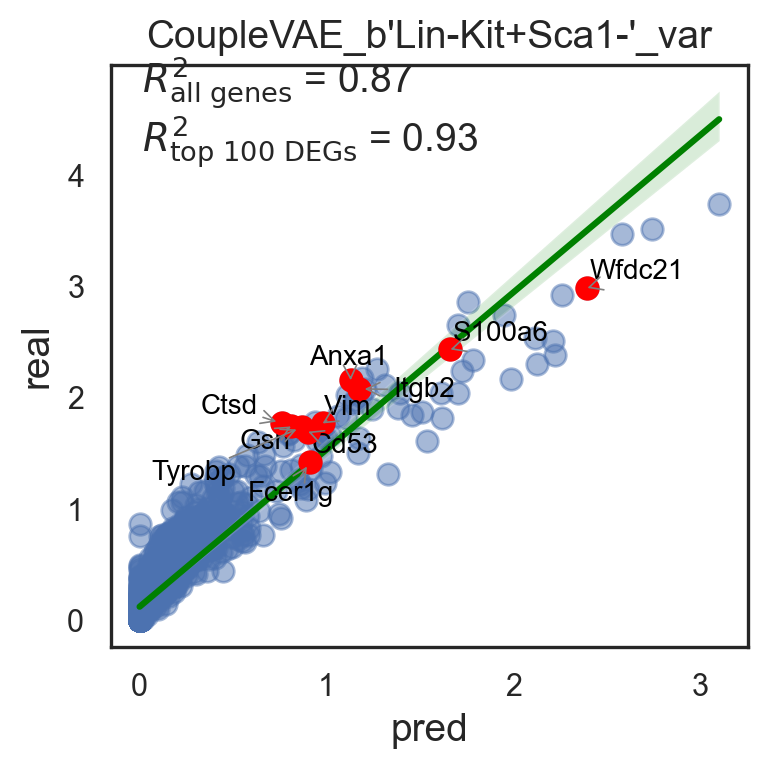

In [39]:
plot_gene_correlation(result, 
                      cond_col="time",
                      axes_map={"x":conditions["pred_stim"],"y":conditions["real_stim"]},
                      genes_of_interest=diff_genes_covid[:30],
                      top_genes=diff_genes_covid,
                      include_legend=False,
                      reg_type='var',
                      label_map={"x":"pred","y":"real"},
                      plot_title=f"CoupleVAE_{cell_type}_var",
                      file_path=f"CoupleVAE_{cell_type}_ot_diffusion_kan_{data_name}_{pert_key}.pdf",
                      show_plot=True,
                      ) 

In [40]:
adata_combined = train.concatenate(test, valid, join='outer', batch_key='study')

C:\Users\jerry-ai\AppData\Local\Temp\ipykernel_30376\893390858.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_combined = train.concatenate(test, valid, join='outer', batch_key='study')


In [41]:
adata_combined

AnnData object with n_obs × n_vars = 84747 × 1622
    obs: 'time', 'population', 'batch', 'study'

In [42]:
test = adata_combined

In [43]:
test_adata_c = test[(test.obs[condition_key]==ctrl_key)&(test.obs[cell_type_key]==cell_type)]  
test_adata_p = test[(test.obs[condition_key]==pert_key)&(test.obs[cell_type_key]==cell_type)]

In [44]:
test_adata_p

View of AnnData object with n_obs × n_vars = 7793 × 1622
    obs: 'time', 'population', 'batch', 'study'

In [45]:
pred = network.predict(test_adata_c, test_adata_p)

In [46]:
pred_adata = anndata.AnnData(pred, 
                             obs={condition_key: [f"{cell_type}_pred_pert"] * len(pred),
                                  cell_type_key: [cell_type] * len(pred)},
                             var={"var_names": test_adata_c.var_names})

In [47]:
pred_adata

AnnData object with n_obs × n_vars = 7793 × 1622
    obs: 'time', 'population'

In [48]:
if issparse(test_adata_c.X):
    test_adata_c.X = test_adata_c.X.A
else:
    test_adata_c.X = test_adata_c.X
ctrl_adata = anndata.AnnData(test_adata_c.X,
                             obs={condition_key: [f"{cell_type}_ctrl"] * len(test_adata_c),
                                  cell_type_key: [cell_type] * len(test_adata_c)},
                             var={"var_names": test_adata_c.var_names})

d:\anaconda\envs\couplevae_env\Lib\site-packages\anndata\_core\anndata.py:602: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
C:\Users\jerry-ai\AppData\Local\Temp\ipykernel_30376\1873556746.py:4: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  test_adata_c.X = test_adata_c.X


In [49]:
if issparse(test_adata_p.X):
    test_adata_p.X = test_adata_p.X.A
else:
    test_adata_p.X = test_adata_p.X

d:\anaconda\envs\couplevae_env\Lib\site-packages\anndata\_core\anndata.py:602: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
C:\Users\jerry-ai\AppData\Local\Temp\ipykernel_30376\3848477140.py:4: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  test_adata_p.X = test_adata_p.X


In [50]:
real_stim_adata = anndata.AnnData(test_adata_p.X,
                                  obs={condition_key: [f"{cell_type}_real_pert"] * len(test_adata_p),
                                       cell_type_key: [cell_type] * len(test_adata_p)},
                                  var={"var_names": test_adata_p.var_names})

In [51]:
all_data = ctrl_adata.concatenate(pred_adata, real_stim_adata)
# all_data.write_h5ad(f"coupleVAE{data_name}_{cell_type}_ot_diffusion_kan_{data_name}_{pert_key}_all.h5ad")

C:\Users\jerry-ai\AppData\Local\Temp\ipykernel_30376\1861705003.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  all_data = ctrl_adata.concatenate(pred_adata, real_stim_adata)


In [52]:
# result=sc.read(f"coupleVAE{data_name}_{cell_type}_ot_diffusion_kan_{data_name}_{pert_key}_all.h5ad")

In [53]:
result = all_data

R-squared for top genes: 0.99
R-squared for all genes: 0.99


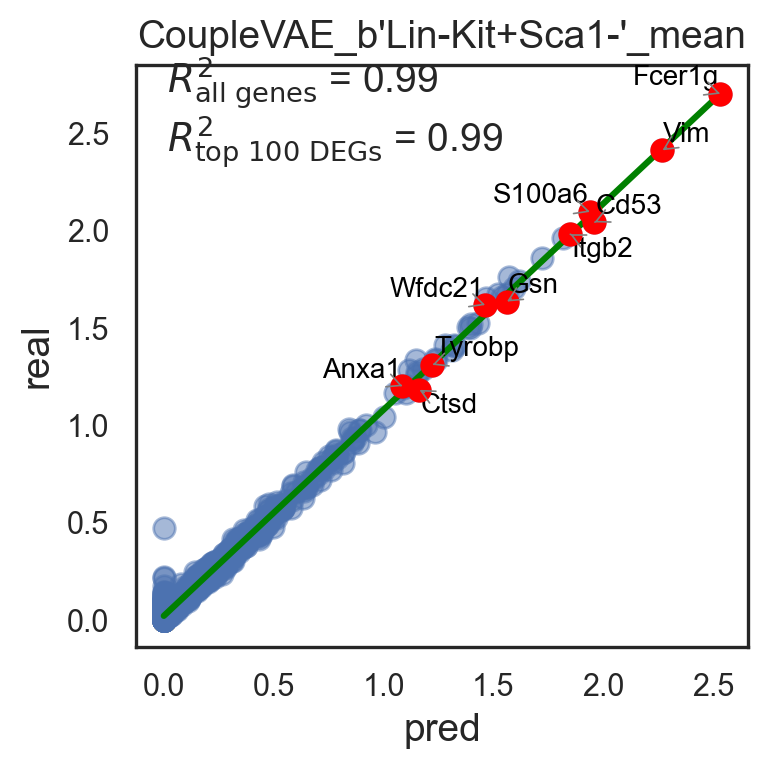

In [54]:
plot_gene_correlation(result, 
                      cond_col="time",
                      axes_map={"x":conditions["pred_stim"],"y":conditions["real_stim"]},
                      genes_of_interest=diff_genes_covid[:30],
                      top_genes=diff_genes_covid,
                      include_legend=False,
                      label_map={"x":"pred","y":"real"},
                      plot_title=f"CoupleVAE_{cell_type}_mean",
                      file_path=f"CoupleVAE_{cell_type}_ot_diffusion_kan_{data_name}_{pert_key}.pdf",
                      show_plot=True,
                      ) 

R-squared for top genes: 0.92
R-squared for all genes: 0.89


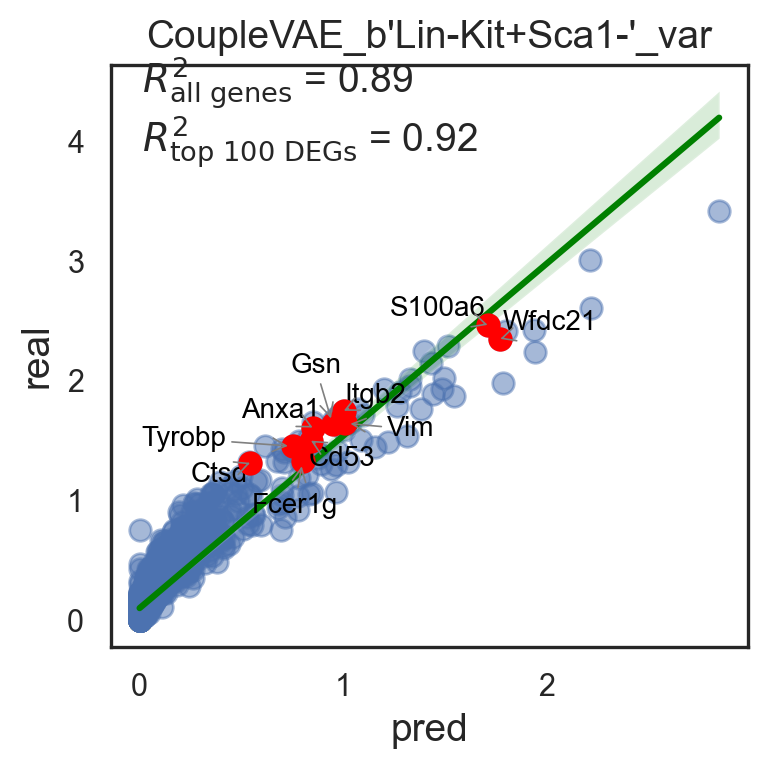

In [55]:
plot_gene_correlation(result, 
                      cond_col="time",
                      axes_map={"x":conditions["pred_stim"],"y":conditions["real_stim"]},
                      genes_of_interest=diff_genes_covid[:30],
                      top_genes=diff_genes_covid,
                      include_legend=False,
                      reg_type='var',
                      label_map={"x":"pred","y":"real"},
                      plot_title=f"CoupleVAE_{cell_type}_var",
                      file_path=f"CoupleVAE_{cell_type}_ot_diffusion_kan_{data_name}_{pert_key}.pdf",
                      show_plot=True,
                      ) 

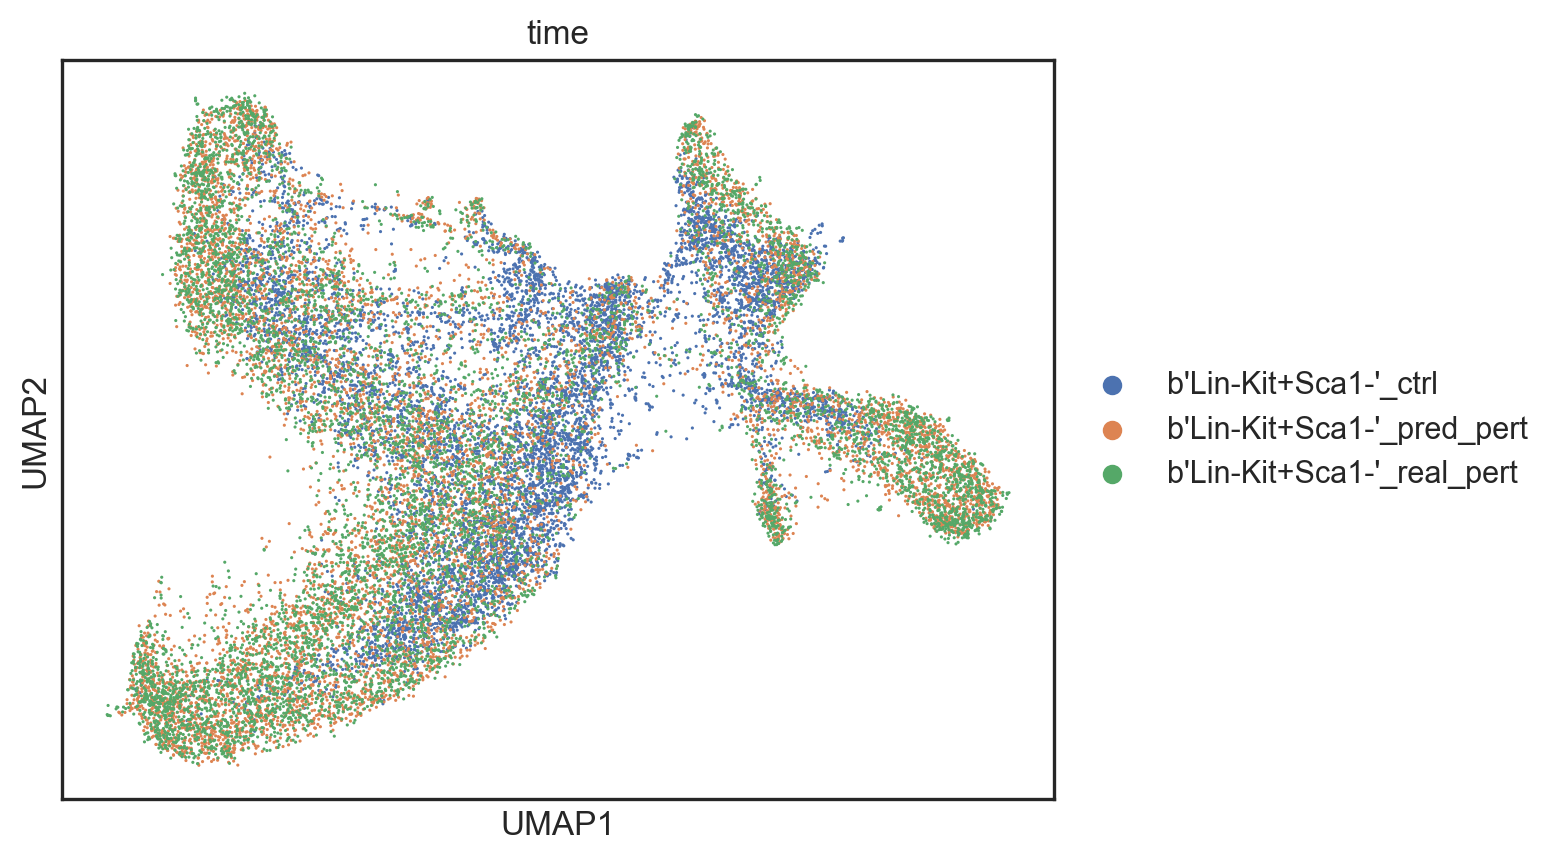

In [56]:
import scanpy as sc

# 假设 AnnData 对象已经加载为 'result'
# 1. 计算邻接关系
sc.pp.neighbors(result, n_neighbors=100, use_rep='X')  # use_rep='X' 是使用PCA降维结果，如果已做PCA。

# 2. 计算UMAP
sc.tl.umap(result)

# 3. 绘制UMAP图，基于细胞类型或者其他分组信息
sc.pl.umap(result, color=['time'], show=True)

In [57]:
import gseapy as gp
import scanpy as sc

In [58]:
enr = gp.enrichr(
    gene_list=diff_genes_covid_list, 
    gene_sets='KEGG_2016',  # 这里选择一个基因集库
    outdir='enrichment_results',  # 输出文件夹
    cutoff=0.02  # p值阈值
)

In [59]:
enr.results.head() 

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2016,Apoptosis Homo sapiens hsa04210,6/140,0.000073,0.009323,0,0,9.415370,89.629509,NFKBIA;GZMB;CSF2RB;CTSD;GADD45G;CTSB
1,KEGG_2016,Lysosome Homo sapiens hsa04142,5/123,0.000383,0.020847,0,0,8.823372,69.418748,PSAP;LITAF;CTSD;IGF2R;CTSB
2,KEGG_2016,Asthma Homo sapiens hsa05310,3/31,0.000492,0.020847,0,0,21.949926,167.173503,FCER1G;PRG2;FCER1A
3,KEGG_2016,Tuberculosis Homo sapiens hsa05152,5/178,0.002010,0.052270,0,0,6.001521,37.267180,FCER1G;ITGAM;ITGB2;CTSD;CAMP
4,KEGG_2016,Legionellosis Homo sapiens hsa05134,3/55,0.002635,0.052270,0,0,11.804917,70.106361,NFKBIA;ITGAM;ITGB2


In [60]:
import pandas as pd
import statsmodels.api as sm

# 假设 enr 结果是一个 Pandas DataFrame
# 提取p值列，例如 "P-value" 列
enrichment_results = enr.results  # 或者从输出文件中读取结果
p_values = enrichment_results['P-value']

# Benjamini-Hochberg (FDR) 校正
p_values_adj = sm.stats.multipletests(p_values, method='fdr_bh')[1]

# 将调整后的p值添加到结果中
enrichment_results['Adj P-value'] = p_values_adj

# # 可以选择保存校正后的结果
# enrichment_results.to_csv('enrichment_results_adjusted.csv', index=False)

# 显示结果
print(enrichment_results)


      Gene_set                                            Term Overlap  \
0    KEGG_2016                 Apoptosis Homo sapiens hsa04210   6/140   
1    KEGG_2016                  Lysosome Homo sapiens hsa04142   5/123   
2    KEGG_2016                    Asthma Homo sapiens hsa05310    3/31   
3    KEGG_2016              Tuberculosis Homo sapiens hsa05152   5/178   
4    KEGG_2016             Legionellosis Homo sapiens hsa05134    3/55   
..         ...                                             ...     ...   
122  KEGG_2016                Alcoholism Homo sapiens hsa05034   1/179   
123  KEGG_2016  Herpes simplex infection Homo sapiens hsa05168   1/185   
124  KEGG_2016      Huntington's disease Homo sapiens hsa05016   1/193   
125  KEGG_2016            Focal adhesion Homo sapiens hsa04510   1/202   
126  KEGG_2016   Proteoglycans in cancer Homo sapiens hsa05205   1/203   

      P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0    0.000073          0.009323          

C:\Users\jerry-ai\AppData\Local\Temp\ipykernel_30376\2419286757.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Adj P-value', y='Term', data=enrichment_df.head(10), palette="viridis")


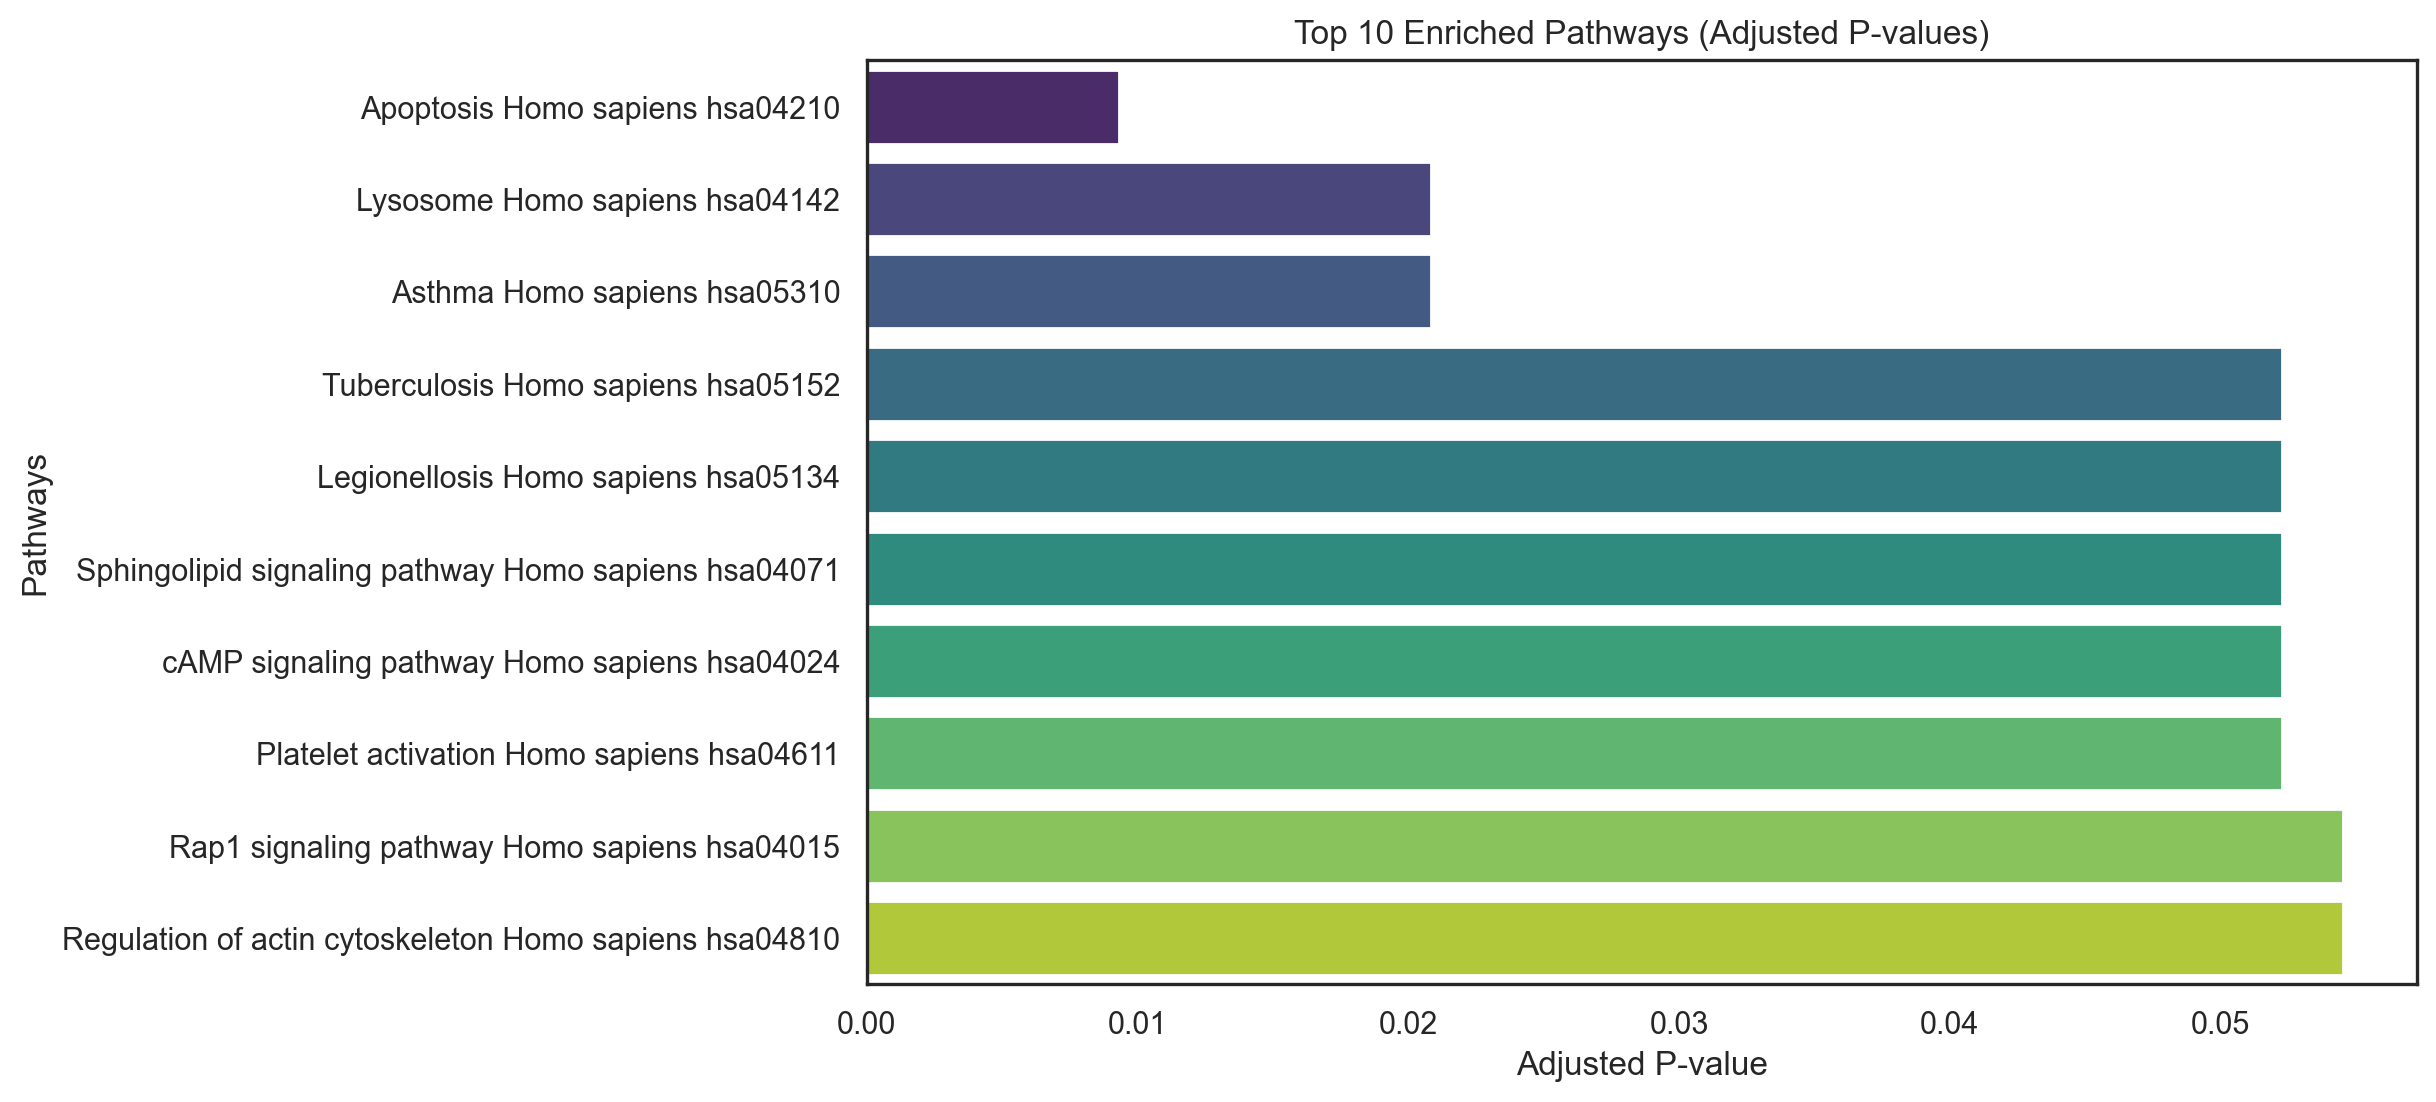

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 enrichr 结果已经加载为 DataFrame 并且进行了 p 值调整
enrichment_df = enr.results

# 绘制柱状图，使用调整后的 p 值（Adj P-value）
plt.figure(figsize=(10, 6))
sns.barplot(x='Adj P-value', y='Term', data=enrichment_df.head(10), palette="viridis")
plt.title("Top 10 Enriched Pathways (Adjusted P-values)")
plt.xlabel("Adjusted P-value")
plt.ylabel("Pathways")
plt.show()


In [62]:
import scanpy as sc
import matplotlib.pyplot as plt
from scipy.sparse import issparse
import numpy as np
import pandas as pd

def find_and_plot_markers(adata, cluster_key='leiden', n_markers=1, 
                          min_diff=0.25, method='t-test', **umap_kwargs):
    """
    自动寻找每类的marker基因并标注在UMAP图上
    
    参数:
    adata: AnnData对象
    cluster_key: 用于分组的列名 (默认 'leiden')
    n_markers: 每类选择的top marker基因数量 (默认 1)
    min_diff: 最小表达差异 (默认 0.25)
    method: 差异表达分析方法 (默认 't-test')
    umap_kwargs: 传递给sc.pl.umap的其他参数
    """
    
    # 1. 执行差异表达分析
    sc.tl.rank_genes_groups(
        adata, 
        groupby=cluster_key, 
        method=method,
        key_added=f'{cluster_key}_markers'
    )
    
    # 2. 提取每类top marker基因
    markers_dict = {}
    results = adata.uns[f'{cluster_key}_markers']
    
    for cluster in np.unique(adata.obs[cluster_key]):
        # 获取该类所有marker基因
        cluster_df = sc.get.rank_genes_groups_df(adata, group=cluster, key=f'{cluster_key}_markers')
        
        # 过滤显著性基因
        cluster_df = cluster_df[
            (cluster_df['pvals_adj'] < 0.05) & 
            (cluster_df['logfoldchanges'] > min_diff)
        ]
        
        # 按表达差异排序并取前n_markers个
        top_markers = cluster_df.sort_values('scores', ascending=False).head(n_markers)['names'].tolist()
        
        if len(top_markers) > 0:
            markers_dict[cluster] = top_markers
    
    # 3. 计算每类在UMAP空间中的中心位置
    umap_coords = adata.obsm['X_umap']
    cluster_centers = {}
    
    for cluster in markers_dict.keys():
        cluster_mask = adata.obs[cluster_key] == cluster
        center = np.median(umap_coords[cluster_mask], axis=0)
        cluster_centers[cluster] = center
    
    # 4. 绘制UMAP图并标注marker基因
    plt.figure(figsize=(10, 8))
    
    # 绘制基础UMAP
    ax = sc.pl.umap(
        adata, 
        color=[cluster_key],
        show=False,
        title=f'UMAP with {cluster_key} clusters and top marker genes',
        legend_loc='on data',
        **umap_kwargs
    )
    
    # 标注marker基因
    texts = []
    for cluster, markers in markers_dict.items():
        center = cluster_centers[cluster]
        for i, gene in enumerate(markers):
            # 计算标注位置 (稍微偏移避免重叠)
            offset = 0.5 * (i+1)
            text_pos = (center[0], center[1] + offset)
            
            # 添加标注
            t = plt.text(
                text_pos[0], text_pos[1], 
                f"{gene}",
                fontsize=10,
                weight='bold',
                ha='center',
                va='center',
                bbox=dict(
                    facecolor='white', 
                    alpha=0.7, 
                    edgecolor='none', 
                    boxstyle='round,pad=0.2'
                )
            )
            texts.append(t)
    
    # 调整标注位置避免重叠
    from adjustText import adjust_text
    adjust_text(
        texts, 
        arrowprops=dict(arrowstyle='-', color='gray', lw=0.5),
        expand_points=(1.2, 1.5),
        expand_text=(1.2, 1.5),
        force_text=0.5,
        only_move={'text': 'xy'}
    )
    
    plt.tight_layout()
    plt.show()
    
    # 返回找到的marker基因
    return markers_dict

d:\anaconda\envs\couplevae_env\Lib\site-packages\scanpy\neighbors\__init__.py:586: UserWarning: You’re trying to run this on 1622 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  X = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)
C:\Users\jerry-ai\AppData\Local\Temp\ipykernel_30376\1892997274.py:13: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)  # 这里使用 Leiden 聚类方法，你可以选择其他方法


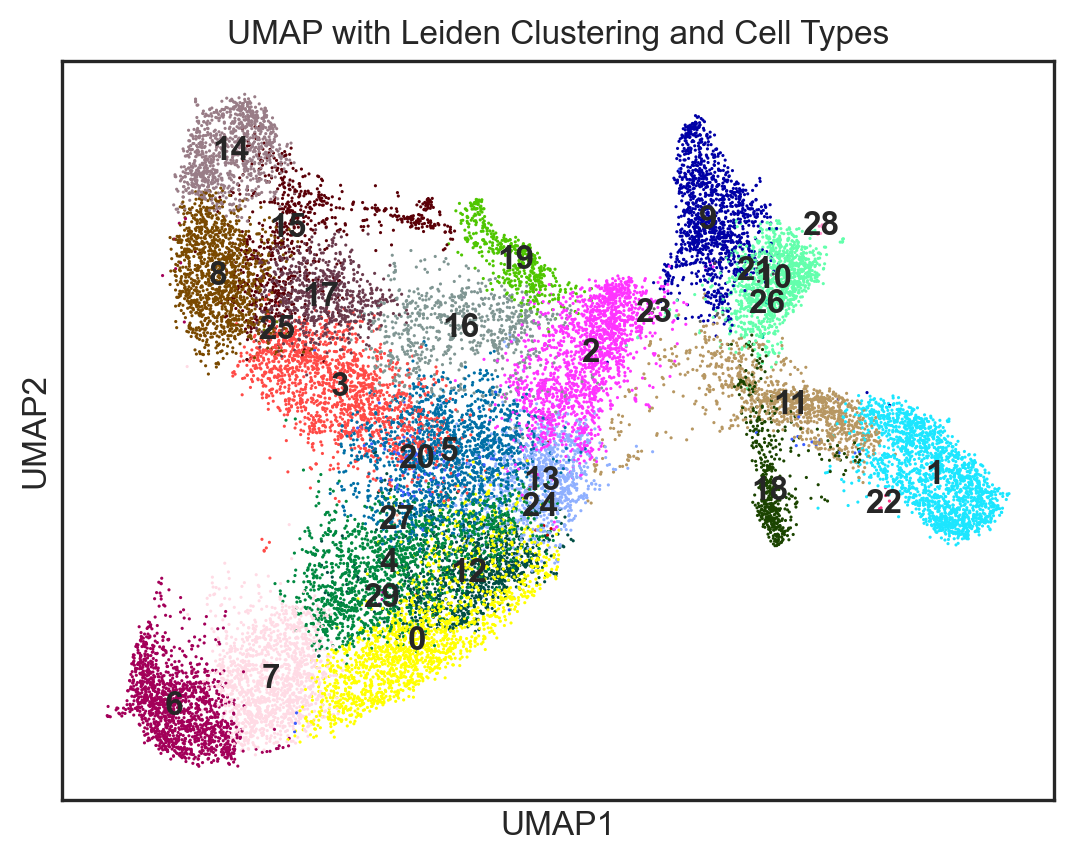

d:\anaconda\envs\couplevae_env\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:456: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
d:\anaconda\envs\couplevae_env\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:458: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
d:\anaconda\envs\couplevae_env\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:461: PerformanceWarning: DataFrame is highly fragmented. 

<Figure size 1000x800 with 0 Axes>

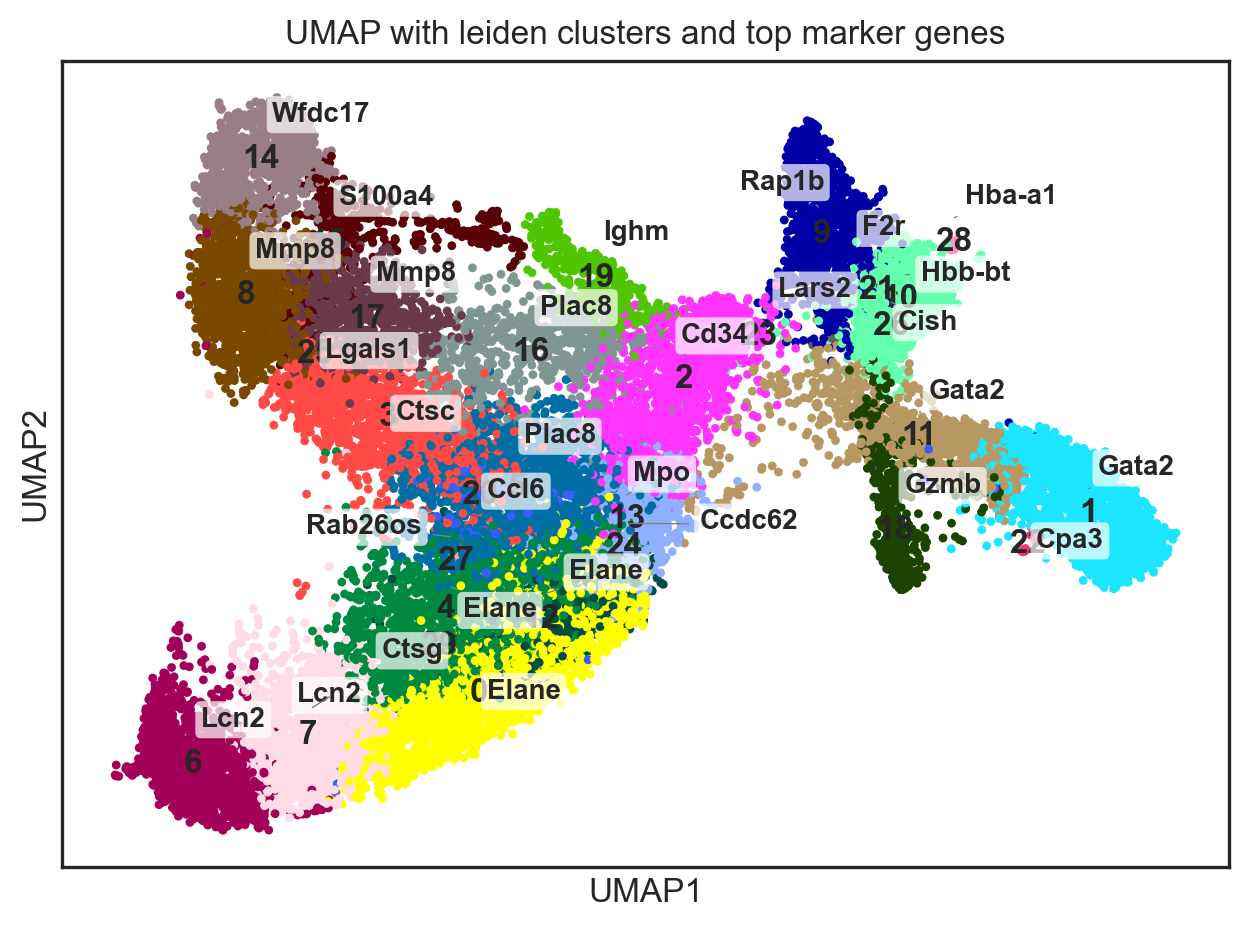

Found markers:
Cluster 0: Elane
Cluster 1: Gata2
Cluster 10: Hbb-bt
Cluster 11: Gata2
Cluster 12: Elane
Cluster 13: Mpo
Cluster 14: Wfdc17
Cluster 15: S100a4
Cluster 16: Plac8
Cluster 17: Mmp8
Cluster 18: Gzmb
Cluster 19: Ighm
Cluster 2: Cd34
Cluster 20: Ccl6
Cluster 21: F2r
Cluster 22: Cpa3
Cluster 23: Lars2
Cluster 24: Ccdc62
Cluster 25: Lgals1
Cluster 26: Cish
Cluster 27: Rab26os
Cluster 28: Hba-a1
Cluster 29: Ctsg
Cluster 3: Ctsc
Cluster 4: Elane
Cluster 5: Plac8
Cluster 6: Lcn2
Cluster 7: Lcn2
Cluster 8: Mmp8
Cluster 9: Rap1b


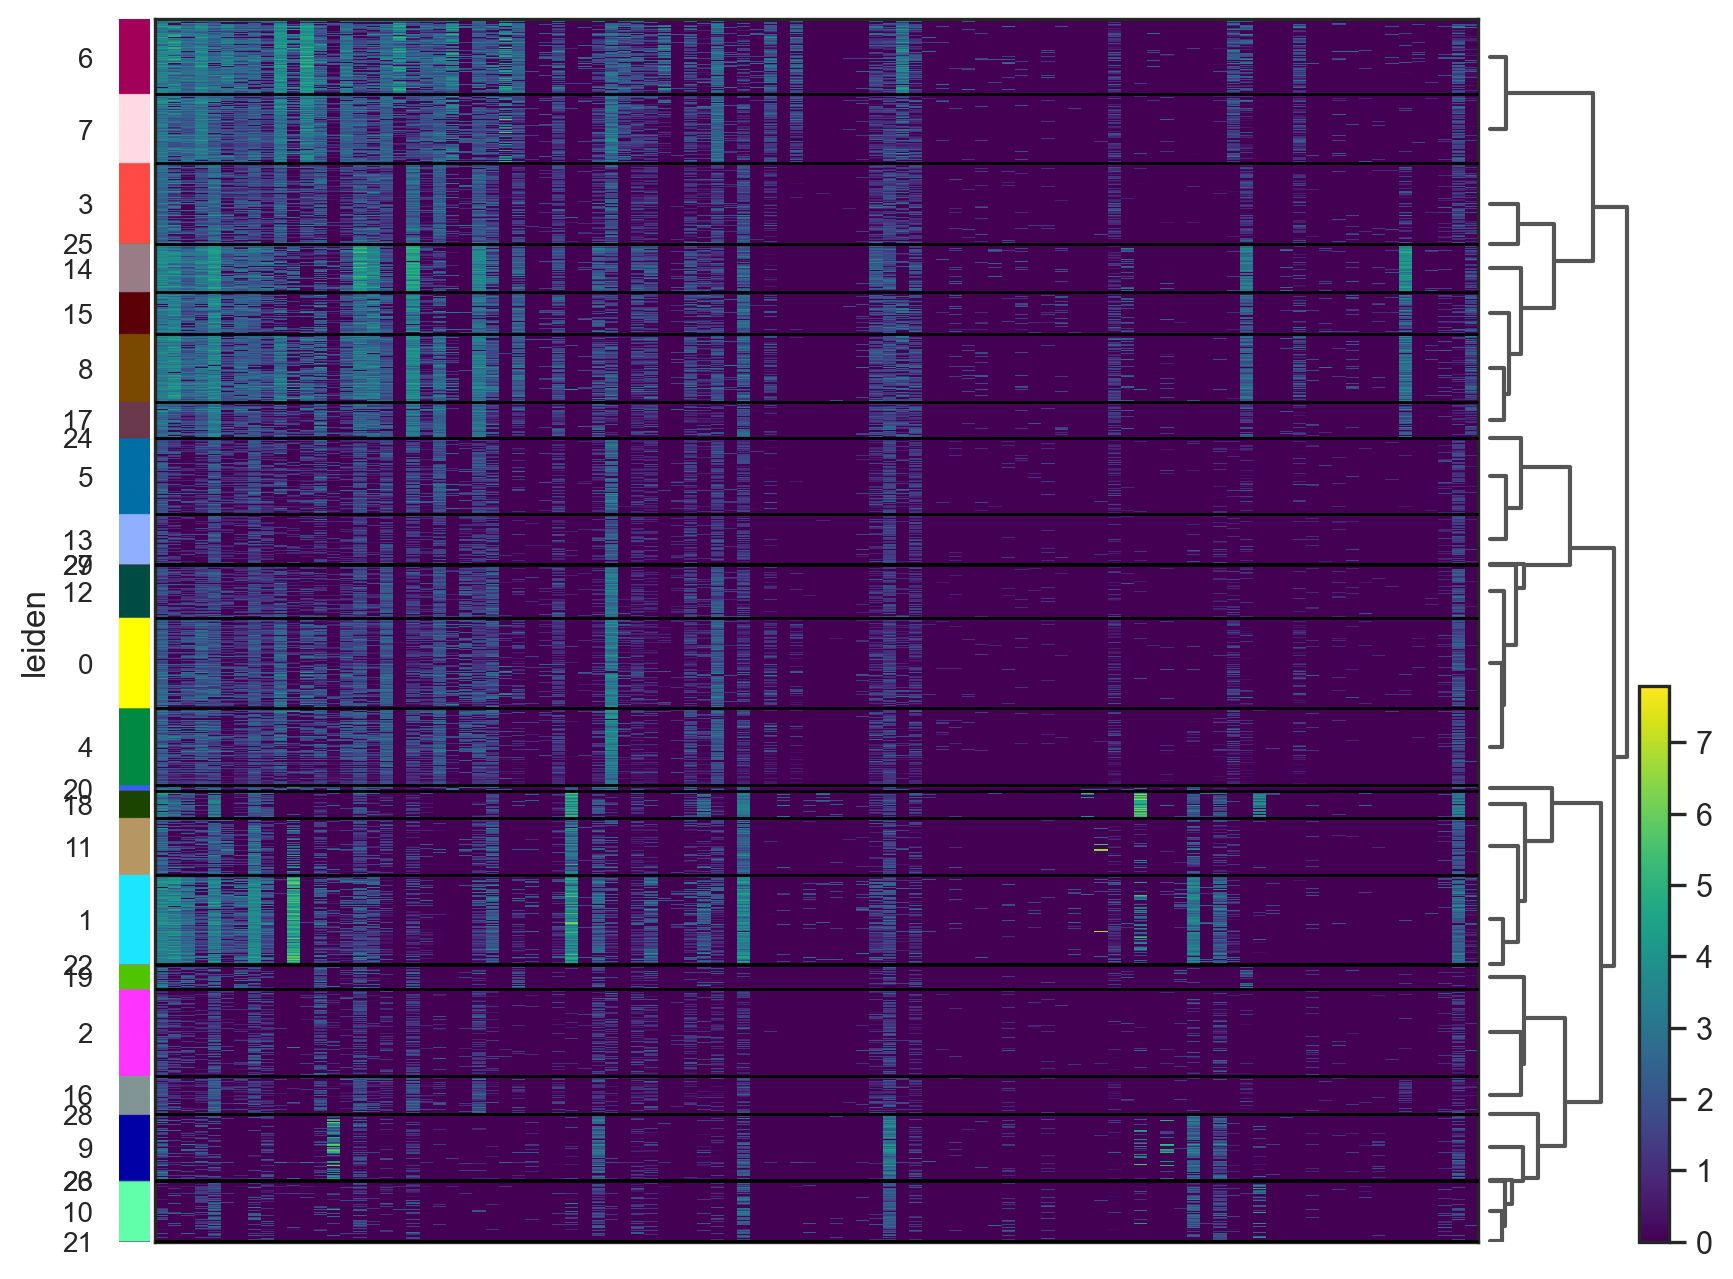

In [63]:
import scanpy as sc
import matplotlib.pyplot as plt

# 提取基因的表达数据
genes_of_interest = diff_genes_covid_list  # 假设这是你感兴趣的基因列表
adata = result  # 假设你已经有一个 AnnData 对象

# 检查这些基因是否在数据中
genes_in_data = [gene for gene in genes_of_interest if gene in adata.var_names]

# 进行聚类，假设你已经进行了聚类分析
sc.pp.neighbors(adata)
sc.tl.leiden(adata)  # 这里使用 Leiden 聚类方法，你可以选择其他方法
sc.pl.umap(
    adata, 
    color=['leiden'],  # 标明聚类和细胞类型
    title='UMAP with Leiden Clustering and Cell Types', 
    legend_loc='on data',  # 控制图例显示位置
    show=True
)
markers = find_and_plot_markers(
    adata,
    cluster_key='leiden',  # 也可以使用 'cell_type'
    n_markers=1,          # 每类标注1个top基因
    min_diff=0.5,         # 最小log2FC阈值
    method='t-test',      # 差异表达分析方法
    color_map='viridis',  # 颜色方案
    size=40               # 点大小
)

# 输出找到的marker基因
print("Found markers:")
for cluster, genes in markers.items():
    print(f"Cluster {cluster}: {', '.join(genes)}")
# 绘制热图并显示聚类结果、基因注释和细胞注释
sc.pl.heatmap(
    adata, 
    var_names=genes_in_data,  # 基因集合
    groupby='leiden',  # 基于聚类结果分组
    cmap='viridis', 
    show=True,
    use_raw=False,  # 如果使用原始数据，请设置为True
    dendrogram=True,  # 显示树状图（如果有聚类结果）
    figsize=(10, 8),  # 调整图形尺寸
)
